## Simple Workflow for Protein Atlass Image Classificacation Kaggle Competition  

Source: https://github.com/ademyanchuk/protein_atlas_baseline/blob/master/protein-1.ipynb

I'd like to share my baseline for this competition. It's based on amazing fastai courses and library 
https://github.com/fastai/fastai

My way was to simply combine 3 1-channel images (discarding yellow images) to 1 RGB 3-channel image with greate tool imagemagick https://www.imagemagick.org/script/index.php

Combining images would be as simple as this command in linux shell:

`convert r.jpg g.jpg b.jpg -channel RGB -combine combined.jpg`

So workflow would assume you have a combined images in your train and test folders.

This code would not get you on top of LB, but provide a nice and simple way to start playing with data and experimenting further.

### Imports

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *

In [3]:
path = Config.data_path()/'atlas'
path.mkdir(exist_ok=True)
path

PosixPath('/home/ubuntu/.fastai/data/atlas')

In [4]:
path.ls()

[PosixPath('/home/ubuntu/.fastai/data/atlas/test_combined'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/test_all'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train_combined'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train_all'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/models'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/sample_submission.csv'),
 PosixPath('/home/ubuntu/.fastai/data/atlas/train.csv')]

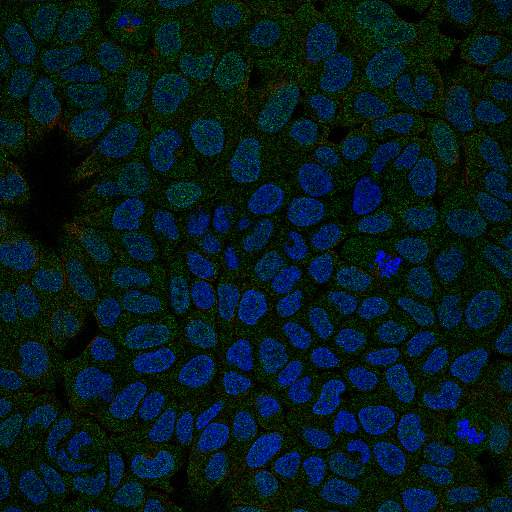

In [5]:
open_image(path/'train_combined/79a6b502-bbb4-11e8-b2ba-ac1f6b6435d0.png')

### Labels 

0.  Nucleoplasm  
1.  Nuclear membrane   
2.  Nucleoli   
3.  Nucleoli fibrillar center   
4.  Nuclear speckles   
5.  Nuclear bodies   
6.  Endoplasmic reticulum   
7.  Golgi apparatus   
8.  Peroxisomes   
9.  Endosomes   
10.  Lysosomes   
11.  Intermediate filaments   
12.  Actin filaments   
13.  Focal adhesion sites   
14.  Microtubules   
15.  Microtubule ends   
16.  Cytokinetic bridge   
17.  Mitotic spindle   
18.  Microtubule organizing center   
19.  Centrosome   
20.  Lipid droplets   
21.  Plasma membrane   
22.  Cell junctions   
23.  Mitochondria   
24.  Aggresome   
25.  Cytosol   
26.  Cytoplasmic bodies   
27.  Rods & rings  

### Data Preparation

In [14]:
np.random.seed(42)

In [15]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [16]:
bs = 64

In [17]:
src = (ImageFileList.from_folder(path)            
       .label_from_csv('train.csv', sep=' ', folder='train_combined', suffix='.png')  
       .random_split_by_pct(0.2))

In [18]:
# start with smaller size
data = (src.datasets()
        .transform(tfms, size=128)
        .databunch(bs=bs).normalize(imagenet_stats))

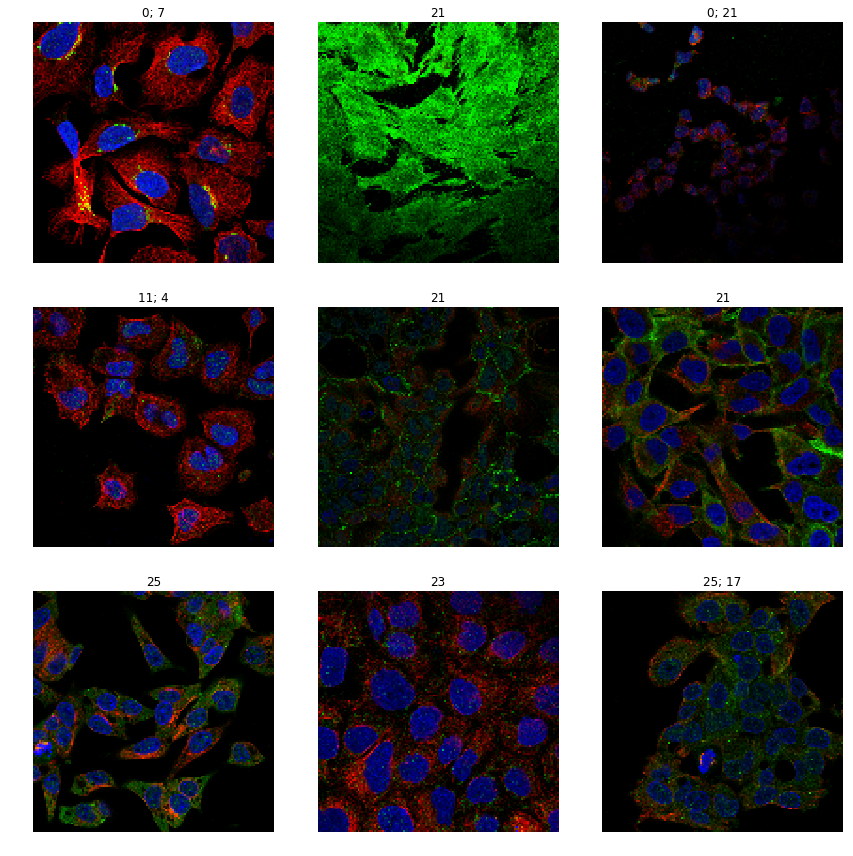

In [19]:
data.show_batch(rows=3, figsize=(12,12))

### Training

In [20]:
# use pretrained model
arch = models.resnet34

In [21]:
f1_score = partial(fbeta, thresh=0.2, beta=1.)
learn = create_cnn(data, arch, metrics=f1_score)

In [30]:
learn.lr_find()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


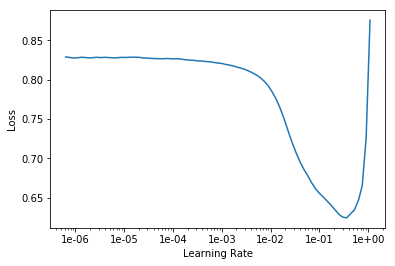

In [31]:
learn.recorder.plot()

In [22]:
lr = 3e-2

In [33]:
learn.fit_one_cycle(5, slice(lr))

Total time: 11:53
epoch  train_loss  valid_loss  fbeta   
1      0.156003    0.158339    0.400787  (02:31)
2      0.158937    0.160086    0.398982  (02:20)
3      0.148682    0.153341    0.463679  (02:19)
4      0.139663    0.134473    0.495411  (02:21)
5      0.135812    0.131136    0.516406  (02:20)



My validation Fbeta does not match really good with LB, it's allways ~40-45% better. But goes up and down as LB score does.

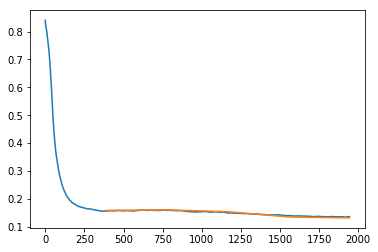

In [34]:
learn.recorder.plot_losses()

In [35]:
learn.save('stage-1-rn34-128')

#### Unfreeze to train pretrained weights a bit

In [ ]:
learn.unfreeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


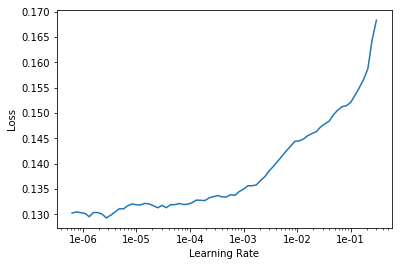

In [25]:
learn.lr_find()
learn.recorder.plot()

In [26]:
learn.fit_one_cycle(5, slice(1e-6, 1e-4))

Total time: 12:10
epoch  train_loss  valid_loss  fbeta   
1      0.134581    0.130848    0.518503  (02:27)
2      0.133937    0.130070    0.522667  (02:26)
3      0.132991    0.129800    0.525404  (02:25)
4      0.132417    0.129265    0.525807  (02:25)
5      0.131232    0.129380    0.526036  (02:25)



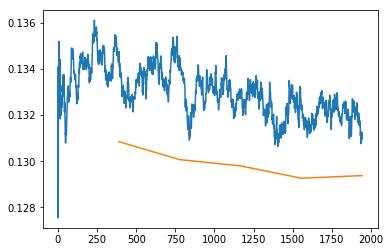

In [27]:
learn.recorder.plot_losses()

In [28]:
learn.save('stage-2-rn34-128')

#### Increase size of images 

In [29]:
data = (src.datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


torch.Size([3, 256, 256])

In [30]:
learn.freeze()

LR Finder complete, type {learner_name}.recorder.plot() to see the graph.


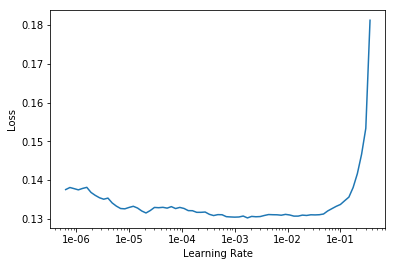

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
lr=1e-2/2

In [33]:
learn.fit_one_cycle(5, slice(lr))

Total time: 19:07
epoch  train_loss  valid_loss  fbeta   
1      0.125685    0.120500    0.570232  (03:52)
2      0.124309    0.118223    0.579937  (03:49)
3      0.118683    0.113787    0.595885  (03:49)
4      0.114614    0.111626    0.604861  (03:48)
5      0.113825    0.111107    0.607537  (03:48)



In [34]:
learn.save('stage-1-256-rn34')

In [35]:
learn.unfreeze()

In [36]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

Total time: 26:12
epoch  train_loss  valid_loss  fbeta   
1      0.116582    0.115342    0.590693  (05:15)
2      0.115310    0.113052    0.602002  (05:14)
3      0.111139    0.107600    0.618917  (05:14)
4      0.105368    0.102594    0.642090  (05:13)
5      0.104934    0.101161    0.649279  (05:14)



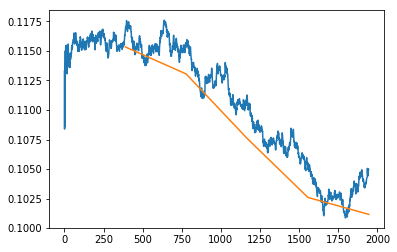

In [37]:
learn.recorder.plot_losses()

In [38]:
learn.save('stage-2-256-rn34')

### Predict 

In [41]:
# add test databunch
learn.data = (src.add_test_folder('test_combined')
        .datasets(ImageMultiDataset)
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/fastai/vision/data.py:122: UserWarning: `ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.
  warnings.warn("`ImageMultiDataset` is deprecated and will soon be removed. Use the data block API.")


In [42]:
preds, _ = learn.get_preds(DatasetType.Test)

/home/ubuntu/anaconda3/envs/pytorch_p36/lib/python3.6/site-packages/torch/nn/functional.py:1124: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [43]:
def get_image_names(data):
    return [fn.stem for fn in data.test_dl.x]

In [44]:
test_ids = get_image_names(learn.data)

In [46]:
def get_tags(predictions, data):
    return [" ".join(data.test_ds.ds.classes[i] for i,el in enumerate(predictions[j] > 0.2) if el==1)
            for j in range(len(predictions))]

In [47]:
tags = get_tags(preds, learn.data)

In [49]:
submit_df = pd.DataFrame(data={'Id':test_ids, 'Predicted': tags})

#### Need to sort by Id, couse the order metters 

In [53]:
submit_df.sort_values(by='Id', inplace=True)

In [55]:
os.makedirs('data/submits', exist_ok=True)

In [56]:
submit_df.to_csv('data/submits/your_submission.csv', header=True, index=False)